# Анализ клиентской базы для фитнес-центра

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.


**Цели:**
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;



- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;

    2) предложить меры по снижению оттока;

    3) определить другие особенности взаимодействия с клиентами.


## Исследование данных

Подключение необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
!pip install -U seaborn 

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


Загрузим и посмотрим данные

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков нет, текстовых, категориальных полей нет. Посмотрим состав данных

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Текущие поля в датасете:
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

- 'Churn' — факт оттока в текущем месяце;

In [4]:
df.duplicated().value_counts()

False    4000
dtype: int64

Дубликатов нет 

Посмотрим средние значения и стандартные отклонения

In [5]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Среднестатистический клиент обладает следующими характеристиками:

- Пол 1
- проживает или работает в районе, где находится фитнес-центр
- не сотрудник компании-партнёра клуба
- записан не в рамках акции «приведи друга» 
- Указан контактный телефон
- длительность текущего действующего абонемента один месяц
- не посещает групповые занятия
- возраст около 29 лет
- суммарная выручка от других услуг фитнес-центра около 136 у.е.
- месяц до окончания текущего действующего абонемента 
- 3 месяца с момента первого обращения в фитнес-центр
- в среднем 1.8 посещений в неделю за все время с начала действия абонемента
- в среднем 1.7 посещений в неделю за предыдущий месяц
- не ушел в отток

Судя по распределениям данных, отдельные выбросы есть, но их нельзя назвать аномальными или не соответствующими смыслу данных. Удалять выбросы нет смысла.

### Средние значения по оттоку

Посмотрим средние данные по оттоку

In [6]:
df.groupby('Churn').agg('mean').round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


По некоторым количественным признакам заметны явные различия. Изучим их подробнее на графиках

### Распределения признаков по оттоку

Построим столбчатые диаграммы для средних значений количественных признаков

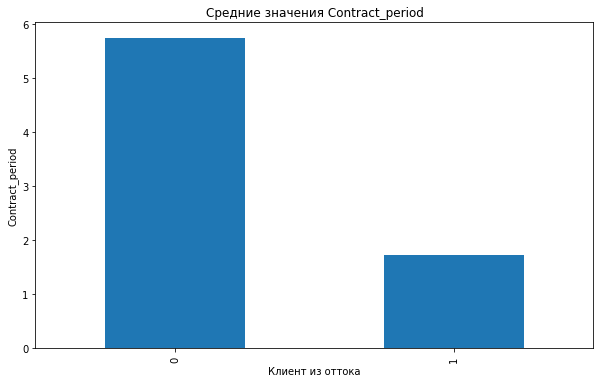

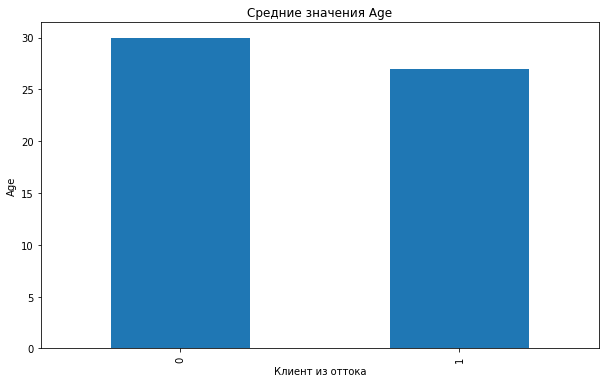

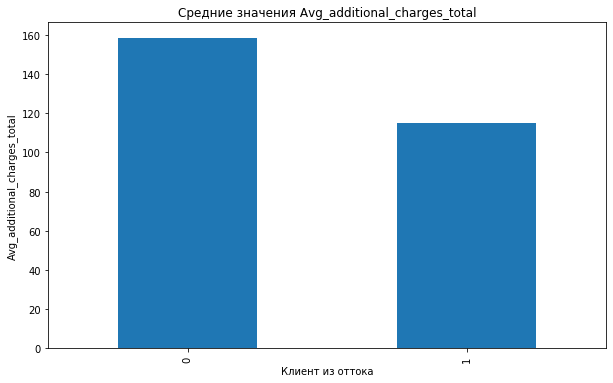

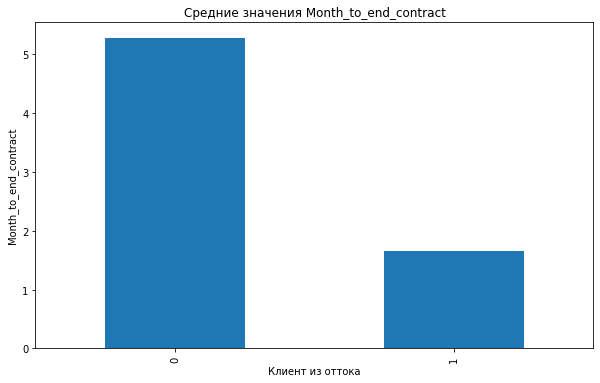

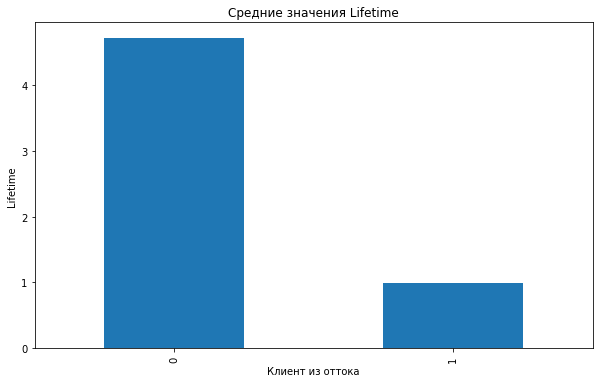

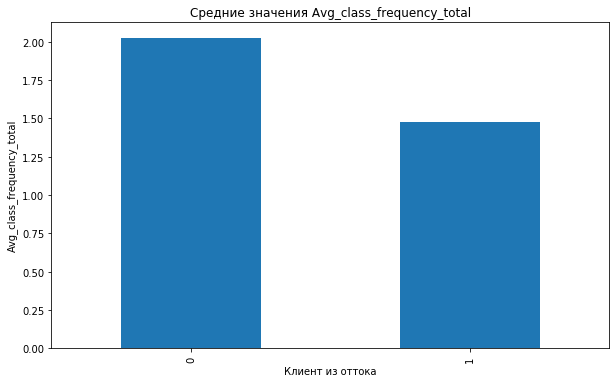

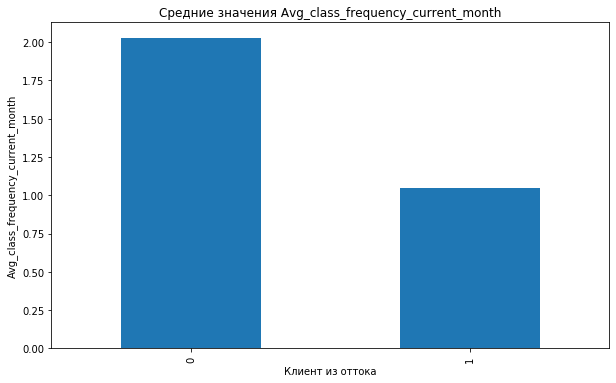

In [7]:
churn_mean = df.groupby(['Churn']).mean() 

for col in df.columns:
    if df[col].nunique() < 3:
        continue
    ax = churn_mean.plot.bar(y= col, stacked=False, figsize=(10, 6), title='Средние значения '+col, legend=False)
    ax.set_xlabel('Клиент из оттока')
    ax.set_ylabel(col)
    plt.show()

Для клиентов, которые ушли в отток, наблюдаем отличия по следующим признакам:

- более низкая средняя длительность текущего действующего абонемента (около 1,7) 
- более низкий средний срок до окончания текущего действующего абонемента  (около 1,5)
- более низкое среднее время с момента первого обращения в фитнес-центр (около 1)

Поделим данные на клиентов из оттока и не из оттока

In [8]:
churn    = df[df['Churn'] == 1]
no_churn = df[df['Churn'] == 0]

Посторим распределения по обоим группам клиентов по каждому признаку

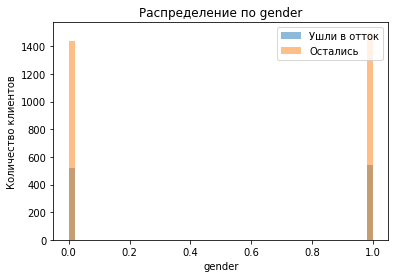

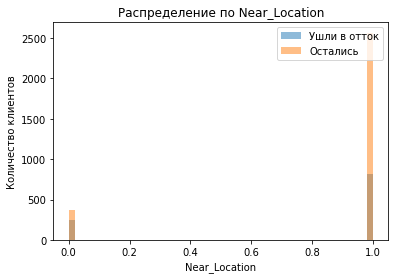

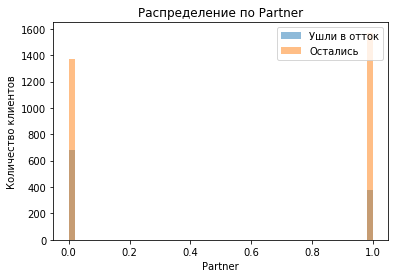

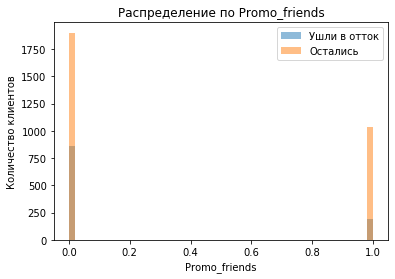

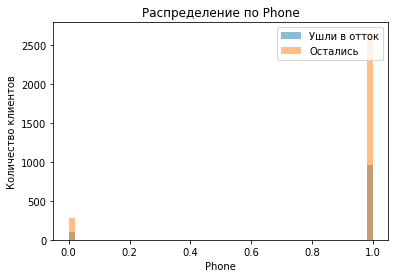

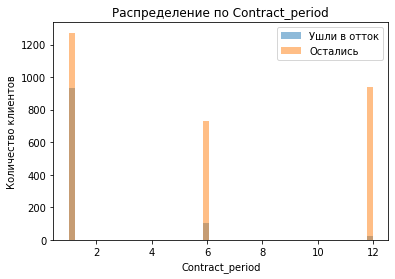

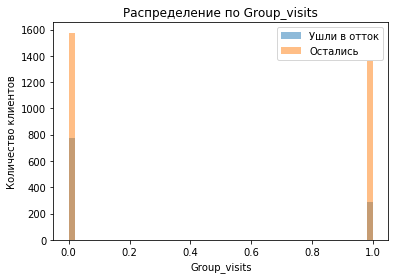

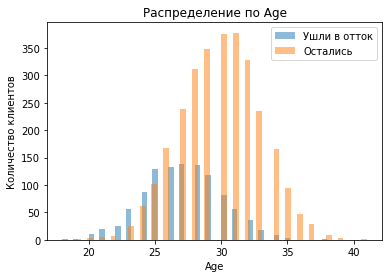

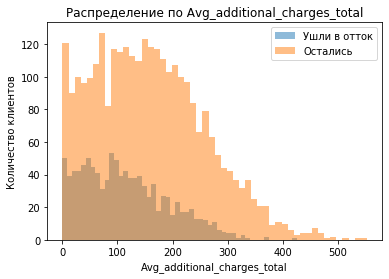

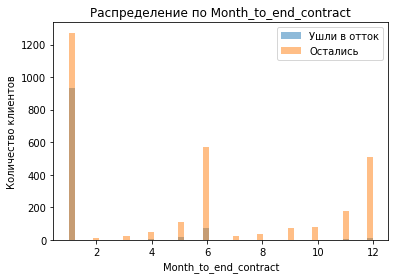

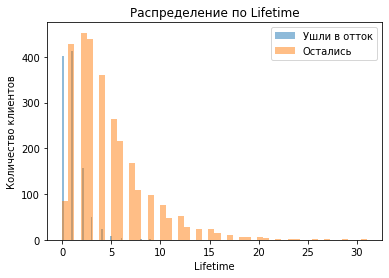

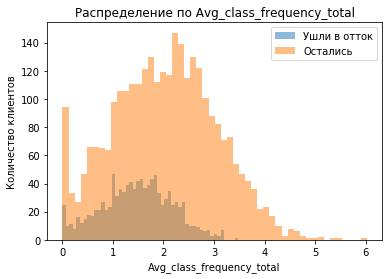

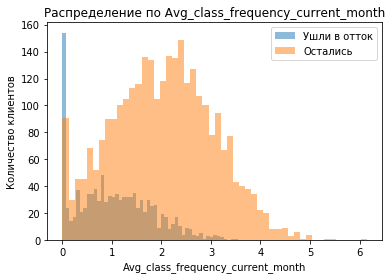

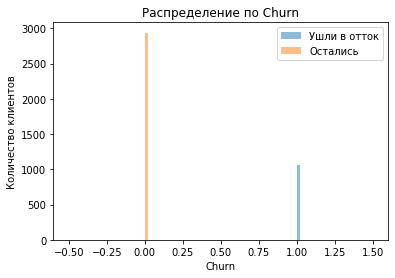

In [9]:
for col in df.columns:    
    plt.ylabel('Количество клиентов')
    plt.xlabel(col)
    plt.title('Распределение по '+ col)
    pyplot.hist(churn[col] ,   bins=50, alpha=0.5, label='Ушли в отток')
    pyplot.hist(no_churn[col], bins=50, alpha=0.5, label='Остались')
    pyplot.legend(loc='upper right')
    pyplot.show()

Для клиентов, которые ушли в отток, наблюдаем отличия по следующим признакам:

- расположение фитнес-центра чаще не в районе проживания или работы
- чаще не сотрудник компании-партнёра клуба
- чаще встречается  факт первоначальной записи в рамках акции «приведи друга» 
- чаще не посещали групповые занятия
- возраст уходящих в среднем на 3 года меньше
- средняя частота посещений в неделю и  суммарная выручка от других услуг фитнес-центра примерно в 1,5 меньше



### Матрица корреляций

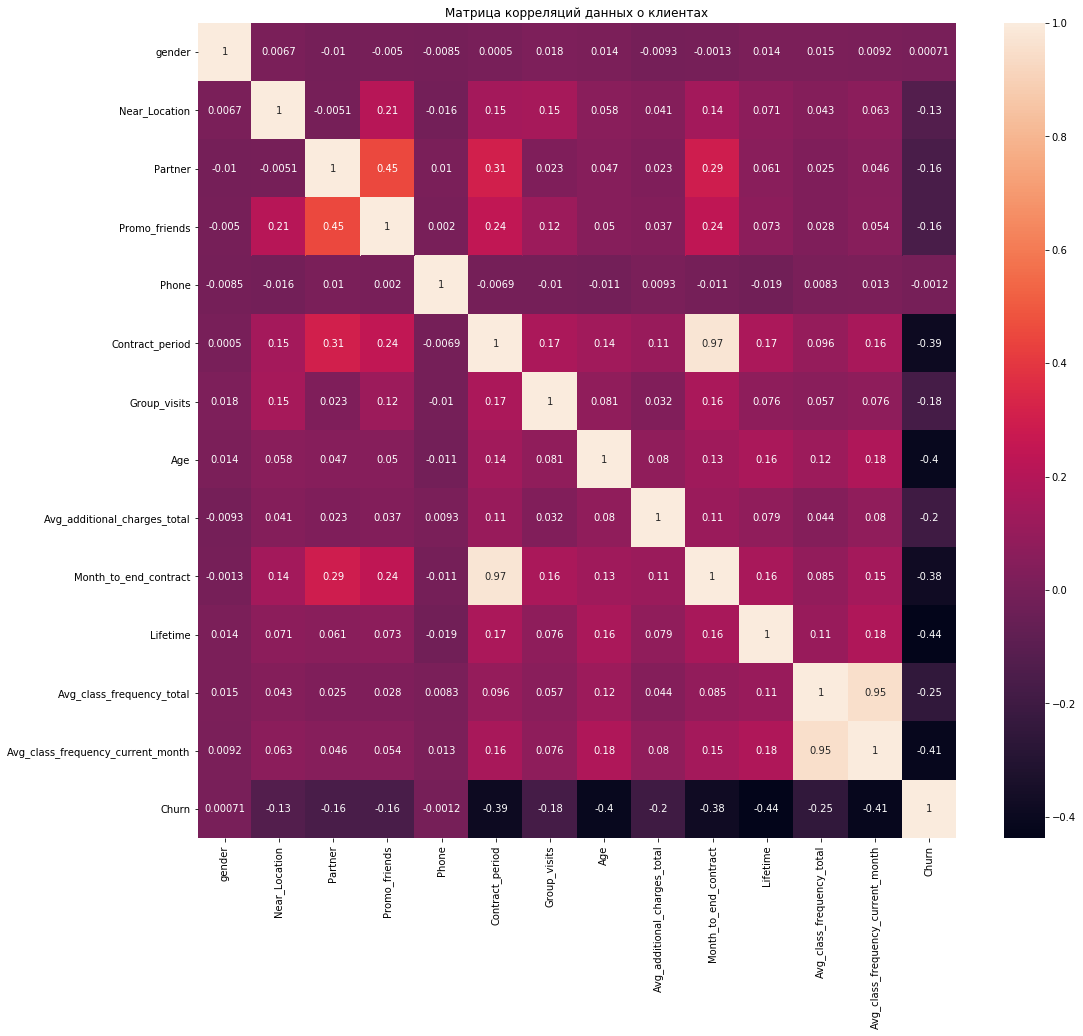

In [10]:
fig, ax = plt.subplots(figsize=(17, 15))   
sns.heatmap(df.corr(), ax=ax, annot = True)
plt.title('Матрица корреляций данных о клиентах')
plt.show()

Две пары признаков имеют высокую корреляцию. Создадим копию датафрейма и удалим в ней по одному признаку из каждой пары, чтобы избежать мультиколлинеарности.

In [11]:
df_cleared = df.drop(['Month_to_end_contract','Avg_class_frequency_current_month'], axis = 1) 

### Вывод

Данные загружены - дубликатов и пропусков нет.


У переменных довольно разные по величине стандартные отклонения. Поэтому перед обучением их нужно будет стандартизировать .


Проанализированы признаки клиентов в разрезе параметра "отток". Наблюдаются очевидные закономерности для клиентов, которые ушли в отток:

- расположение фитнес-центра чаще не в районе проживания или работы
- чаще не сотрудник компании-партнёра клуба
- чаще не посещали групповые занятия
- средняя частота посещений в неделю и суммарная выручка от других услуг фитнес-центра примерно в 1,5 меньше

Матрица корреляций показала явную мультиколлинеарность у двух пар признаков.

## Модель прогнозирования оттока клиентов

Выделим признаки и целевую переменную

In [12]:
X = df.drop('Churn', axis = 1)
y = df['Churn']


X_cleared = df_cleared.drop('Churn', axis = 1)
y_cleared = df_cleared['Churn']

### Разделение выборок

Разделим данные на обучающую выборку и проверочную. Поскольку каждый клиент не связан с другими, будем использовать случайное разделение без учета времени.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,  stratify = y)

X_train_cleared, X_test_cleared, y_train_cleared, y_test_cleared = train_test_split(X_cleared, y_cleared, test_size=0.2, random_state=0,  stratify = y_cleared)

Выделим колонки с небинарными признаками

In [14]:
non_binars = []

for col in df.columns:
    if df[col].unique().sum() != 1:
        non_binars.append(col)

non_binars        

['Contract_period',
 'Age',
 'Avg_additional_charges_total',
 'Month_to_end_contract',
 'Lifetime',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month']

Выделим колонки с небинарными признаками для датафрейма, у которого отброшены мультиколлениарные колонки

In [15]:
non_binars_cleared = []

for col in df_cleared.columns:
    if df_cleared[col].unique().sum() != 1:
        non_binars_cleared.append(col)

non_binars_cleared

['Contract_period',
 'Age',
 'Avg_additional_charges_total',
 'Lifetime',
 'Avg_class_frequency_total']

### Стандартизация данных

In [16]:

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()


X_train_st             = X_train.copy()
X_test_st              = X_test.copy()
X_train_st[non_binars] = scaler.fit_transform(X_train[non_binars])  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st[non_binars]  = scaler.fit_transform(X_test[non_binars])


scaler_cleared = StandardScaler()

X_train_st_cleared = X_train_cleared.copy()  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st_cleared  = X_test_cleared.copy()
X_train_st_cleared[non_binars_cleared] = scaler_cleared.fit_transform(X_train_cleared[non_binars_cleared])  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st_cleared[non_binars_cleared] = scaler_cleared.fit_transform(X_test_cleared[non_binars_cleared])

### Обучение моделей и оценка моделей

Для бинарной классификации подходят модели логистической регрессии и случайный лес.

Создадим функцию, которая обучает модель, делает предсказание и тестирует его по трём метрикам: 
- доля правильных ответов (accuracy)
- точность (precision)
- полнота (recall)

In [17]:
def learn_and_test(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred    = model.predict(X_test)
    
    accuracy  = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    recall    = round(recall_score(y_test, y_pred), 2)
    
    return [accuracy, precision, recall]

Создадим датафрейм, чтобы сохранять и сравнивать результаты

In [18]:
metrics = pd.DataFrame( columns=['model','accuracy', 'precision' , 'recall' ])

Соберем данные по модели логистической регрессии для начальных исходных данных

In [19]:
metrics.loc[len(metrics)]  = ['LogisticRegression'] +  learn_and_test(LogisticRegression(solver='liblinear', random_state=0), X_train_st, y_train, X_test_st, y_test)

Соберем данные по модели случайного леса для начальных исходных данных

In [20]:
metrics.loc[len(metrics)]  = ['RandomForest'] + learn_and_test(RandomForestClassifier(n_estimators=100, random_state=0), X_train_st, y_train, X_test_st, y_test)

Соберем данные по модели логистической регрессии для данных с удаленными мультиколлинеарными признаками 

In [21]:
metrics.loc[len(metrics)]  = ['LogisticRegression_cleared'] + learn_and_test(LogisticRegression(solver='liblinear', random_state=0), X_train_st_cleared, y_train_cleared, X_test_st_cleared, y_test_cleared)

Соберем данные по модели  случайного леса для данных с удаленными мультиколлинеарными признаками 

In [22]:
metrics.loc[len(metrics)]  = ['RandomForest_cleared'] +  learn_and_test(RandomForestClassifier(n_estimators=100, random_state=0), X_train_st_cleared, y_train_cleared, X_test_st_cleared, y_test_cleared)
metrics

,model,accuracy,precision,recall
0,LogisticRegression,0.93,0.90,0.85
1,RandomForest,0.92,0.87,0.82
2,LogisticRegression_cleared,0.91,0.82,0.83
3,RandomForest_cleared,0.90,0.82,0.77


Как ни странно, лучшие метрики выдали модели, обученные по данным с мультиколлинеарными признаками.

Точность чуть лучше у модели случайного леса.

Полнота чуть лучше у модели линейной регрессии.

Будем считать, что модель логистической регрессии справилась лучше. Обучим модель логистической регрессии с мультиколлиниарными признаками еще раз.

In [23]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Посмотрим на важность признаков для обученной модели

In [24]:
pd.DataFrame({'names':X_train_st.columns, 'values':model.coef_[0]}).sort_values(by='values', ascending=False)

,names,values
11,Avg_class_frequency_total,3.108038
0,gender,-0.039509
2,Partner,-0.174637
4,Phone,-0.224375
1,Near_Location,-0.228786
3,Promo_friends,-0.290909
8,Avg_additional_charges_total,-0.562658
9,Month_to_end_contract,-0.620013
5,Contract_period,-0.686050
6,Group_visits,-0.809581


С точки зрения здравого смысла модель получилась довольно абсурдной:

Две схожие характеристики:

- средняя частота посещений в неделю за все время с начала действия абонемента
- средняя частота посещений в неделю за предыдущий месяц

считаются как диаметрально противоположные. Первая максимально влияет на то, что клиент уйдет. Вторая максимально влияет на то, что клиент останется. Видимо, влияет мультиколлениарность признаков.

------------------

Обучим модель на данных без мультиколлениарности:



In [25]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st_cleared, y_train_cleared)
    
pd.DataFrame({'names':X_train_st_cleared.columns, 'values':model.coef_[0]}).sort_values(by='values', ascending=False)

,names,values
0,gender,0.037873
2,Partner,-0.112840
1,Near_Location,-0.256610
3,Promo_friends,-0.342138
4,Phone,-0.456085
8,Avg_additional_charges_total,-0.542144
10,Avg_class_frequency_total,-0.691804
6,Group_visits,-0.727087
7,Age,-1.143831
5,Contract_period,-1.341561


Полученная градация признаков выглядит более адекватно:
- незначительно на вероятность оттока влияет пол 0

- чем больше возраст, длительность контракта и время с момента первого обращения, тем меньше вероятность оттока

### Прогноз оттока на следующий месяц

Для каждого клиента, который не попал в отток, спрогнозируем, уйдет ли он в отток в следующем месяце

In [26]:
X_churn                     = df_cleared[df_cleared['Churn'] == 0]
X_churn                     = X_churn.drop('Churn', axis=1)
X_churn[non_binars_cleared] = scaler.fit_transform(X_churn[non_binars_cleared])
no_churn['chrun_predict']   = model.predict(X_churn)

no_churn.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,chrun_predict
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,1
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,1


Посчитаем долю клиентов, которые уйдут в отток по прогнозу

In [27]:
no_churn['chrun_predict'].mean()

0.18849948962232052

### Вывод


Модели логистической регрессии и случайный лес показали себя примерно одинаково по метрике Доля правильных ответов. По метрике Точность чуть лучше модель случайного леса. По метрике Полнота чуть лучше модель логистической регрессии.

Были замечены противоречия в важности признаков. Были отброшены мультиколлениарные признаки. После этого метрики чуть ухудшились, но модель стало можно интерпретировать с точки зрения здравого смысла.

В итоге была обучена модель логистической регрессии. Сделан прогноз по клиентам, которые не ушли в отток. По прогнозу около 19% клиентов уйдут в отток в следующем месяце.


## Кластеризация клиентов

Построим дендрограмму по имеющимся данным

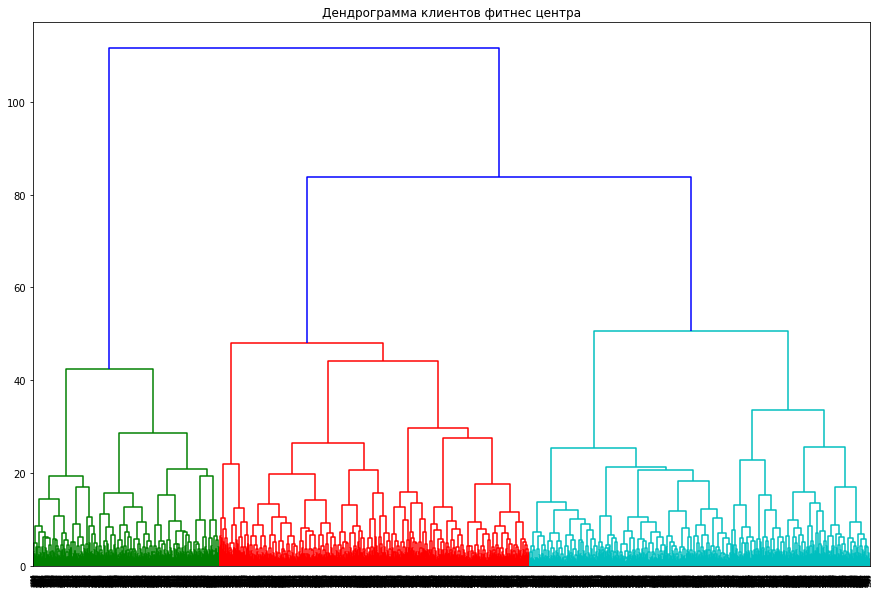

In [28]:
X_st = df.drop('Churn', axis=1)
X_st[non_binars] = scaler.fit_transform(df[non_binars])

linked = linkage(X_st, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма клиентов фитнес центра')
plt.show()

По графику можно увидеть от 4 до 6 крупных кластеров - в зависимости от степени детализации. Будем считать что кластеров 5.

### Кластеризация клиентов

Воспользуемся алгоритмом "К средних"

In [29]:
km               = KMeans(n_clusters = 5, random_state= 0 ) # задаём число кластеров, равное 5
X_sc             = df.copy()
X_sc[non_binars] = scaler.fit_transform(df[non_binars])
labels           = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

Добавим данные о кластерах в датасет

In [30]:
df['cluster'] = labels

### Средние значения кластеров

In [31]:
clusters_mean_values = df.groupby('cluster').agg('mean').round(2)
clusters_mean_values

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
0,0.52,0.77,0.35,0.19,0.91,1.52,0.29,26.02,105.98,1.47,1.22,1.43,1.05,0.86
1,0.51,0.93,0.72,0.49,0.90,11.99,0.54,29.81,164.10,10.98,4.25,1.98,1.97,0.03
2,0.47,0.83,0.47,0.28,0.91,2.75,0.38,30.80,161.62,2.57,3.05,1.15,1.06,0.19
3,0.53,0.88,0.46,0.29,0.86,3.88,0.46,29.73,149.14,3.46,12.95,1.93,1.94,0.00
4,0.53,0.85,0.43,0.28,0.91,2.93,0.43,30.05,156.75,2.74,3.60,2.90,2.90,0.06


Сохраним некоторые выдающиеся значения признаков

In [32]:
high_churn                           = clusters_mean_values.sort_values(by='Churn', ascending=False).head(1).index[0]
high_churn_сontract_period           = clusters_mean_values.sort_values(by='Contract_period', ascending=False).head(1).index[0]
low_gender                           = clusters_mean_values.sort_values(by='gender').head(1).index[0]
high_churn_lifetime                  = clusters_mean_values.sort_values(by='Lifetime', ascending=False).head(1).index[0]
high_Avg_class_frequency_total       = clusters_mean_values.sort_values(by='Avg_class_frequency_total', ascending=False).head(1).index[0]

print('Самая высокая доля оттока в кластере {}'.format(high_churn))
print('Самый длинный срок текущего действующего абонемента в кластере {}'.format(high_churn_сontract_period))
print('Самый высокая доля пола 0 в кластере {}'.format(low_gender))
print('Самый низкий отток в кластере {}'.format(high_churn_lifetime))
print('Самая высокая средняя частота посещений в кластере {}'.format(high_Avg_class_frequency_total))

Самая высокая доля оттока в кластере 0
Самый длинный срок текущего действующего абонемента в кластере 1
Самый высокая доля пола 0 в кластере 2
Самый низкий отток в кластере 3
Самая высокая средняя частота посещений в кластере 4


### Распределения признаков для кластеров


Выведем распределение для каждого признака

In [33]:
for col in df.columns:
    if col == 'cluster':
        continue
        
    print('Распределение', col,'по кластерам')
    print(df.groupby('cluster')[col].describe().reset_index())
    print()
    print()

Распределение gender по кластерам
   cluster  count      mean       std  min  25%  50%  75%  max
0        0  948.0  0.522152  0.499773  0.0  0.0  1.0  1.0  1.0
1        1  909.0  0.509351  0.500188  0.0  0.0  1.0  1.0  1.0
2        2  902.0  0.473392  0.499569  0.0  0.0  0.0  1.0  1.0
3        3  285.0  0.526316  0.500185  0.0  0.0  1.0  1.0  1.0
4        4  956.0  0.529289  0.499403  0.0  0.0  1.0  1.0  1.0


Распределение Near_Location по кластерам
   cluster  count      mean       std  min  25%  50%  75%  max
0        0  948.0  0.768987  0.421703  0.0  1.0  1.0  1.0  1.0
1        1  909.0  0.930693  0.254115  0.0  1.0  1.0  1.0  1.0
2        2  902.0  0.825942  0.379369  0.0  1.0  1.0  1.0  1.0
3        3  285.0  0.880702  0.324709  0.0  1.0  1.0  1.0  1.0
4        4  956.0  0.847280  0.359905  0.0  1.0  1.0  1.0  1.0


Распределение Partner по кластерам
   cluster  count      mean       std  min  25%  50%  75%  max
0        0  948.0  0.348101  0.476620  0.0  0.0  0.0  1.0  1.0
1   

Бросается в глаза, что в одном из кластеров вообще нет оттока

Чтобы нагляднее представить особенности признаков у разных кластеров, построим графики их распределений

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


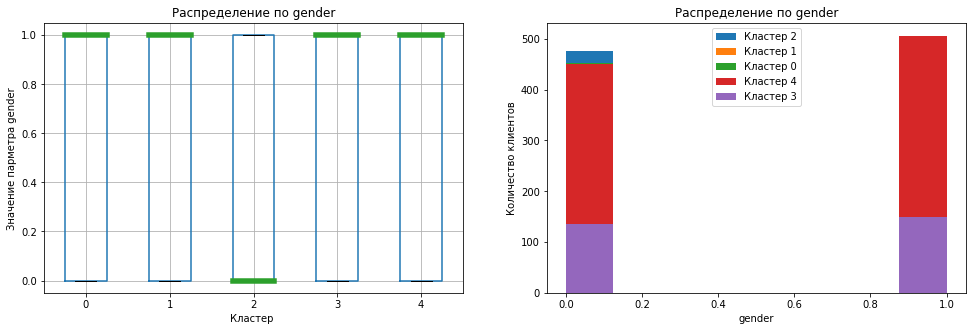

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


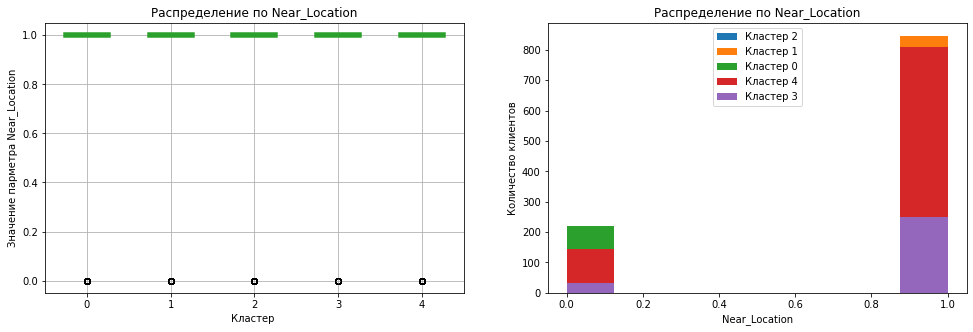

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


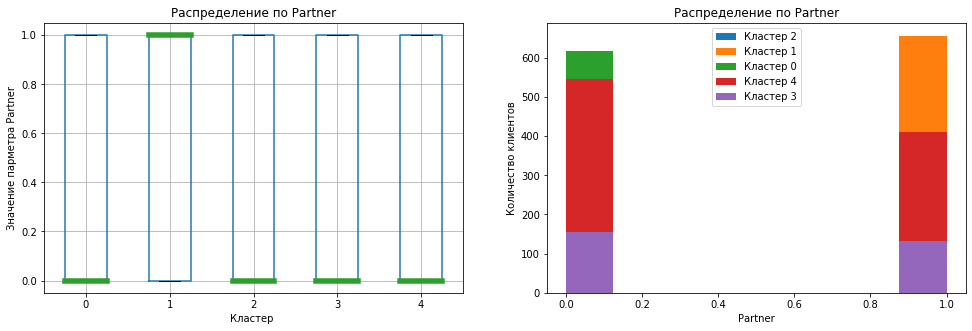

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


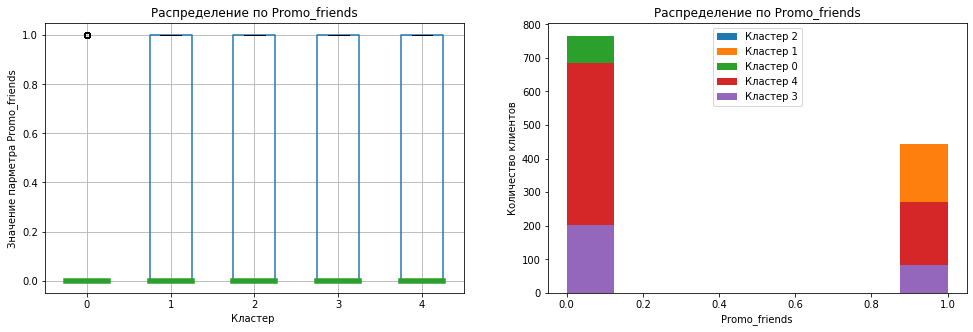

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


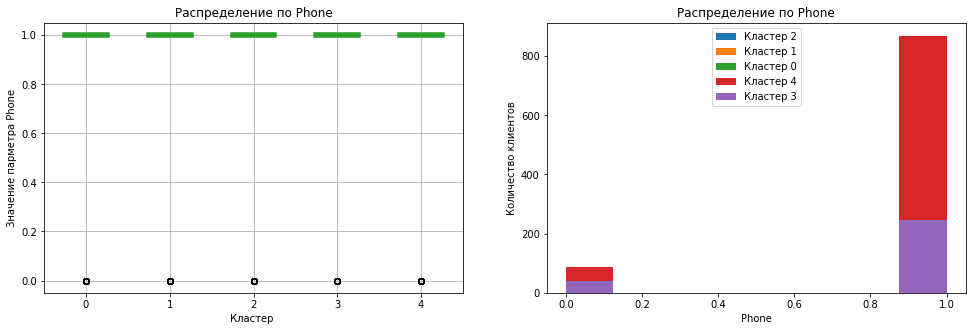

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


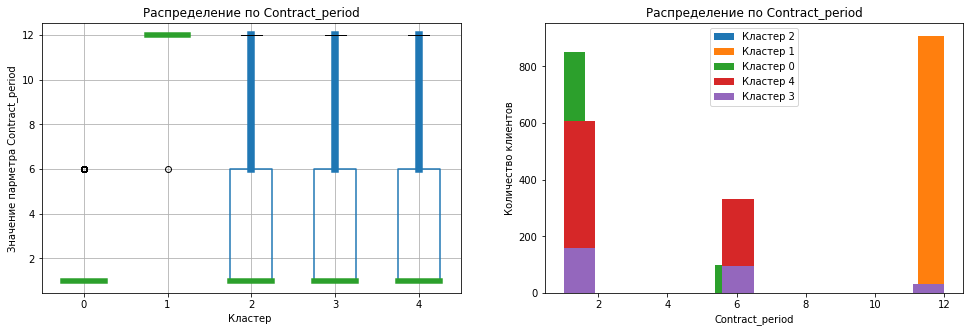

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


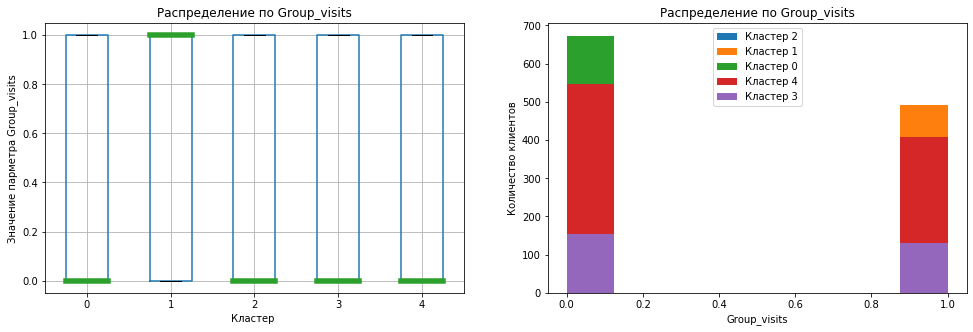

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


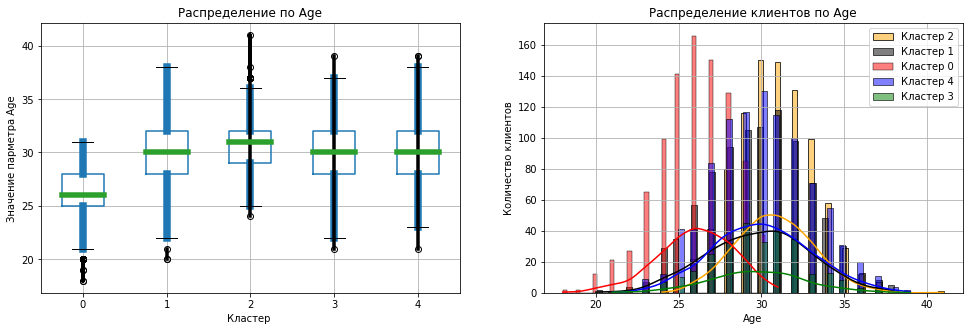

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


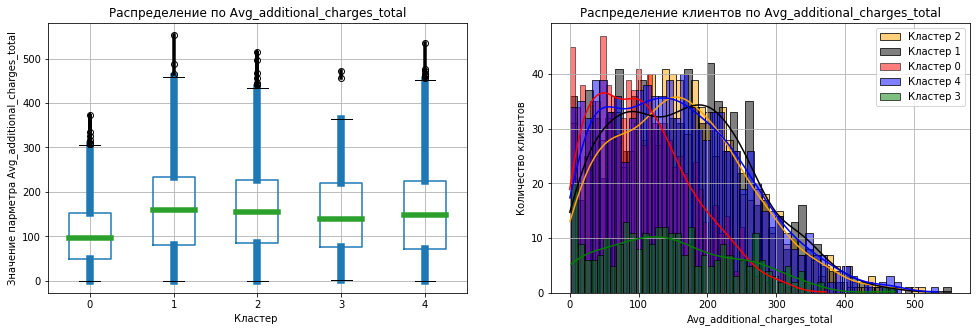

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


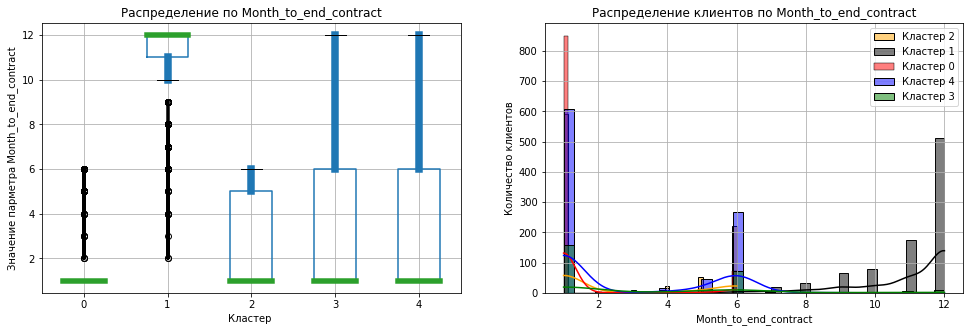

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


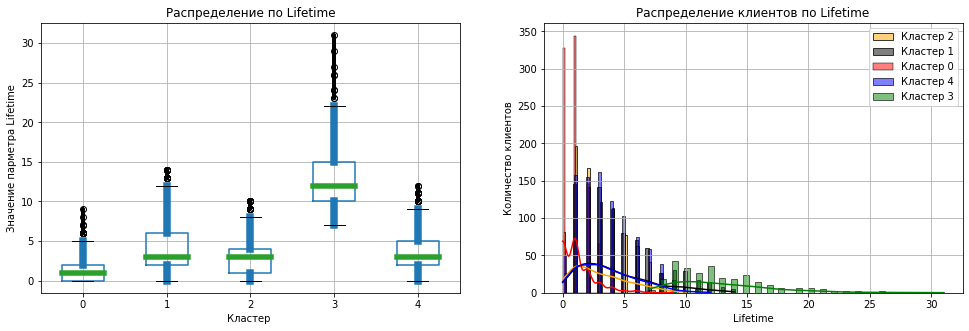

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


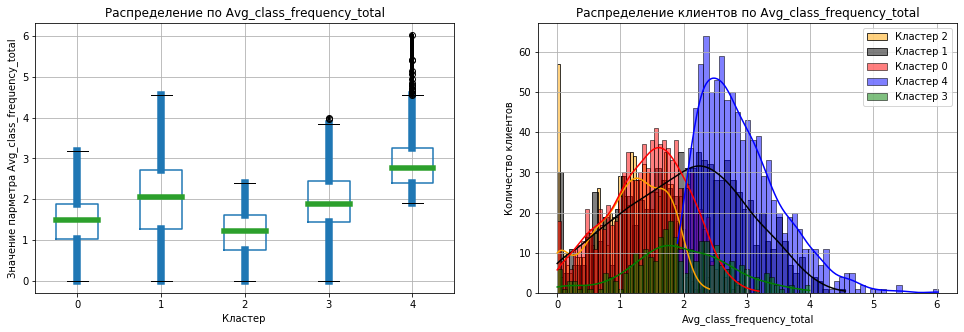

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


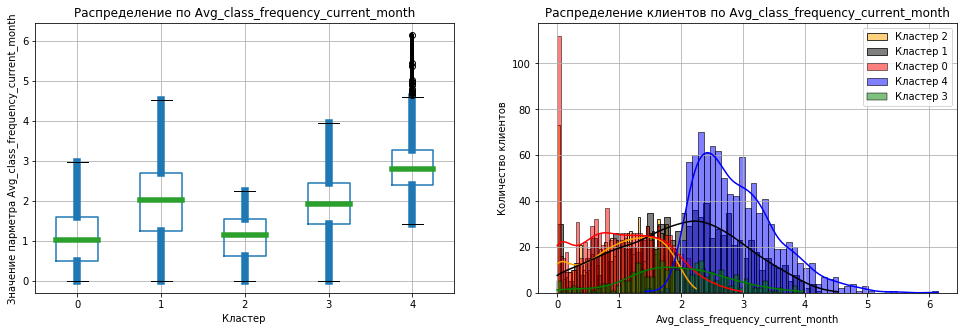

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


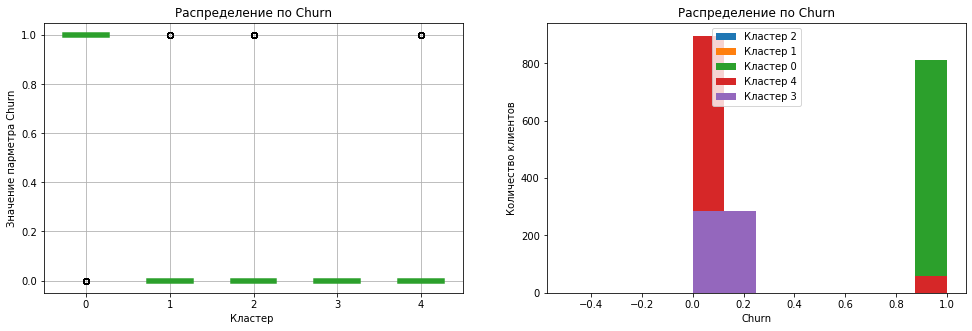

In [34]:
clusters = df['cluster'].unique()
colors   = ['red', 'black', 'orange', 'green', 'blue']


for col in df.columns:
    
    if col == 'cluster':
        continue
        
    bins = 3 * df[col].nunique()
    
    if bins > 50:
        bins = 50    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    
    
    df.boxplot(column=col, 
               figsize=(5,5), 
               by='cluster' , 
               boxprops=dict(linestyle='-', linewidth=1.5),
               flierprops=dict(linestyle='-', linewidth=3.5),
               medianprops=dict(linestyle='-', linewidth=5.5),
               whiskerprops=dict(linestyle='-', linewidth=7.5),
               ax = ax1
               
              )
    
    ax1.set_title( 'Распределение по '+ col)
    plt.suptitle('')
    ax1.set_ylabel('Значение парметра '+ col)
    ax1.set_xlabel('Кластер ')
       
    
    

    if bins > 30:        

        for cluster in clusters:
            data  = df[df['cluster'] == cluster]
            color = colors[cluster]
            label = 'Кластер ' + str(cluster)

            sns.histplot(data = data, bins= bins,  x=col, kde= True, label = label, color = color, pthresh=0.5, ax=ax2)


        ax2.grid(zorder=0)
        ax2.set_title('Распределение клиентов по '+ col)
        ax2.set_xlabel(col)
        ax2.set_ylabel('Количество клиентов')
        plt.legend()  
        plt.show()
        
    else:    
    
        ax2.set_ylabel('Количество клиентов')
        ax2.set_xlabel(col)
        ax2.set_title('Распределение по '+ col)
        for cluster in clusters:
            data = df[df['cluster'] == cluster]
            clustername = 'Кластер ' + str(cluster)
            bins = 4 * data[col].nunique()
            if bins > 50:
                bins = 50

            pyplot.hist(data[col] ,  bins = bins, stacked=True,  label= clustername, histtype='bar')

        plt.axes(ax2)
        pyplot.legend(loc='upper center')
        pyplot.show()

In [35]:
print('В кластере {} низкие большинство показателей и высокий отток'.format(high_churn))
print()
print('В кластере {} \nсотрудник компании-партнёра клуба \nвысокая длительность текущего действующего абонемента \nпосещает групповые визиты \nдлинный срок до окончания текущего действующего абонемента '.format(high_churn_сontract_period))
print()
print('В кластере {} Пол чаще 0'.format(low_gender))

print()
print('В кластере {} чаще длительное время с момента первого обращения в фитнес-центр  '.format(high_churn_lifetime))
print()
print('В кластере {} высокая средняя частота посещений  '.format(high_Avg_class_frequency_total))

В кластере 0 низкие большинство показателей и высокий отток

В кластере 1 
сотрудник компании-партнёра клуба 
высокая длительность текущего действующего абонемента 
посещает групповые визиты 
длинный срок до окончания текущего действующего абонемента 

В кластере 2 Пол чаще 0

В кластере 3 чаще длительное время с момента первого обращения в фитнес-центр  

В кластере 4 высокая средняя частота посещений  


### Доли оттока по кластерам

Выведем данные по оттоку из кластеров в порядке возрастания

In [36]:
df.groupby('cluster').agg({'Churn':'mean'}).sort_values(by='Churn')

,Churn
cluster,
3,0.000000
1,0.025303
4,0.062762
2,0.185144
0,0.855485


In [37]:
print('Кластер {} наиболее надёжен.'.format(high_churn_lifetime))
print('Кластер {} наиболее склонен к оттоку.'.format(high_churn ))

Кластер 3 наиболее надёжен.
Кластер 0 наиболее склонен к оттоку.


### Вывод


**Портреты типичных клиентов из разных кластеров**

In [38]:
print('Для кластера {} характерены: \n - низкая доля клиентов с записью в рамках акции «приведи друга» \n - низкая длительность текущего действующего абонемента \n - ниже возраст \n - низкая  суммарная выручка от других услуг фитнес-центра \n - малое время с момента первого обращения в фитнес-центр \n - высокий отток'.format(high_churn))

Для кластера 0 характерены: 
 - низкая доля клиентов с записью в рамках акции «приведи друга» 
 - низкая длительность текущего действующего абонемента 
 - ниже возраст 
 - низкая  суммарная выручка от других услуг фитнес-центра 
 - малое время с момента первого обращения в фитнес-центр 
 - высокий отток


In [39]:
print('В кластере {} средний клиент чаще \n - сотрудник компании-партнёра клуба \n - с высокой длительностью текущего действующего абонемента \n - посещает групповые визиты \n - длинный срок до окончания текущего действующего абонемента '.format(high_churn_сontract_period))

В кластере 1 средний клиент чаще 
 - сотрудник компании-партнёра клуба 
 - с высокой длительностью текущего действующего абонемента 
 - посещает групповые визиты 
 - длинный срок до окончания текущего действующего абонемента 


In [40]:
print('В кластере {} Пол чаще 0'.format(low_gender))


В кластере 2 Пол чаще 0


In [41]:
print('В кластере {} чаще длительное время с момента первого обращения в фитнес-центр  '.format(high_churn_lifetime))

В кластере 3 чаще длительное время с момента первого обращения в фитнес-центр  


In [42]:
print('В кластере {} высокая средняя частота посещений  '.format(high_Avg_class_frequency_total))

В кластере 4 высокая средняя частота посещений  


## Вывод

### Выявлены ключевые признаки, влияющие на отток

В порядке убывания значимости:

- короткое время с момента первого обращения в фитнес-центр
- малая длительность текущего действующего абонемента
- возраст моложе 27 лет
- непосещение групповых занятий
- низкая средняя частота посещений 


### Прогноз по оттоку

По клиентам которые остались, сделано предсказание об оттоке. Вероятно, 19% из них уйдут в отток в следующем месяце.


### Группы клиентов

Выявлено 4 кластера клиентов. Основные признаки кластеров ниже. Выведем группы в порядке убывания процента оттока:



Группа А  (самый высокий отток)
 - низкая доля клиентов с записью в рамках акции «приведи друга» 
 - низкая длительность текущего действующего абонемента 
 - ниже возраст 
 - низкая  суммарная выручка от других услуг фитнес-центра 
 - малое время с момента первого обращения в фитнес-центр 
----------------

Группа Б
- Пол чаще 0

----------------

Группа В
- высокая средняя частота посещений  

----------------

Группа Г
 - сотрудник компании-партнёра клуба 
 - с высокой длительностью текущего действующего абонемента 
 - посещает групповые визиты 
 - длинный срок до окончания текущего действующего абонемента 

----------------
Группа Д (самый низкий отток)
- чаще длительное время с момента первого обращения в фитнес-центр  








### Предлагаемые меры по снижению оттока:

- организовывать больше партнерств с работодателями, находящимся в районе, где находится фитнес-центр
- предлагать длительные абонементы со скидкой
- вовлекать клиентов в посещение групповых занятий (больше видов занятий, уплотнить график)
- упор в рекламе на возрастную категорию 27+
- стимулировать частые посещения (бонусы клуба, соревнования - нематериальная мотивация и т.д.)


### Другие особенности взаимодействия с клиентами
- вести допродажи дополнительных услуг
- развивать программу «приведи друга» - в ней пока только 15% оттока